Reading: |██████████████████████████████████████████████████| 100.0% 
Dataset count:  43550  Shape:  (43550, 39, 264)
Labels count:  43550  Shape:  (43550,)
Sample:
Label:  0
Train set size :  34840
Test set size :  8710
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.6408 - precision: 0.5227 - recall: 0.1752 - AUC: 0.6159
Epoch 00001: val_accuracy improved from -inf to 0.63835, saving model to model_best_weights_1.hdf5
123/123 [==============================] - 264s 2s/step - loss: 0.6376 - accuracy: 0.6408 - precision: 0.5227 - recall: 0.1752 - AUC: 0.6159 - val_loss: 0.6537 - val_accuracy: 0.6383 - val_precision: 0.5556 - val_recall: 0.0858 - val_AUC: 0.6057
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.6553 - precision: 0.5621 - recall: 0.2489 - AUC: 0.6531
Epoch 00002: val_accuracy improved from 0.6

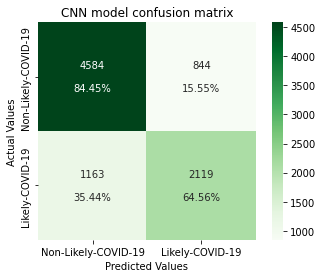

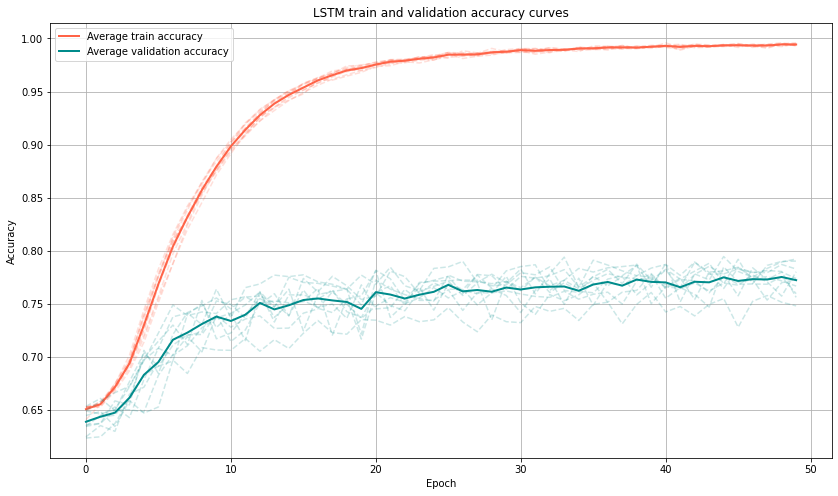

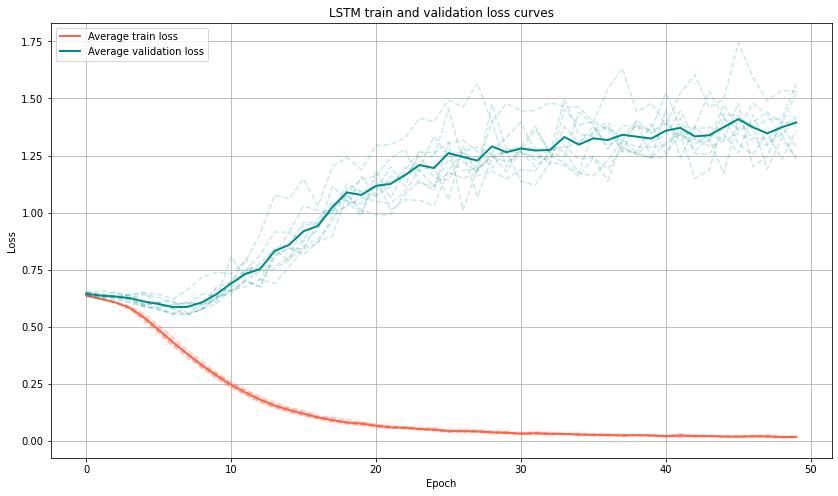

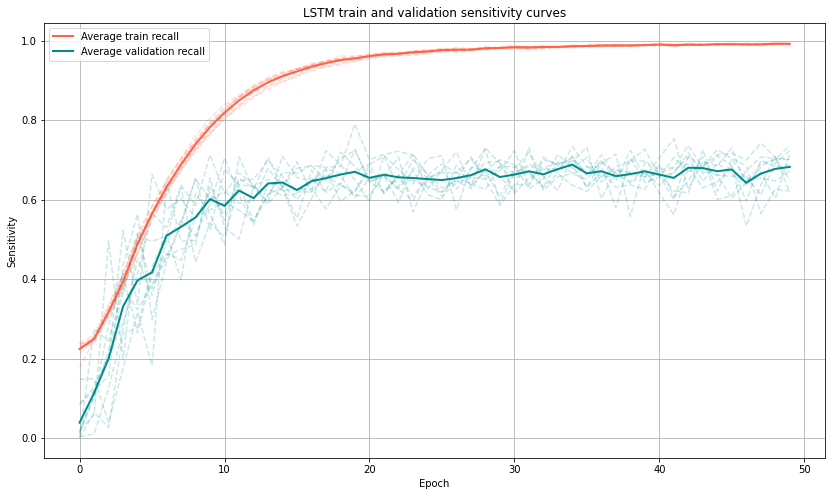

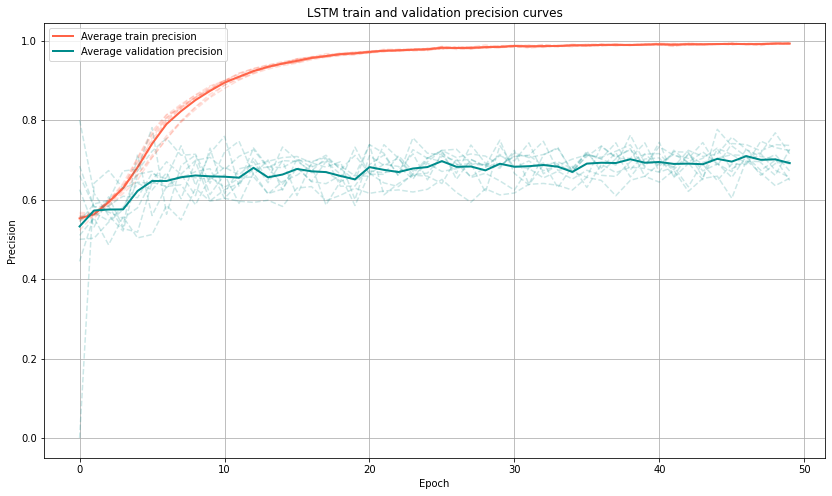

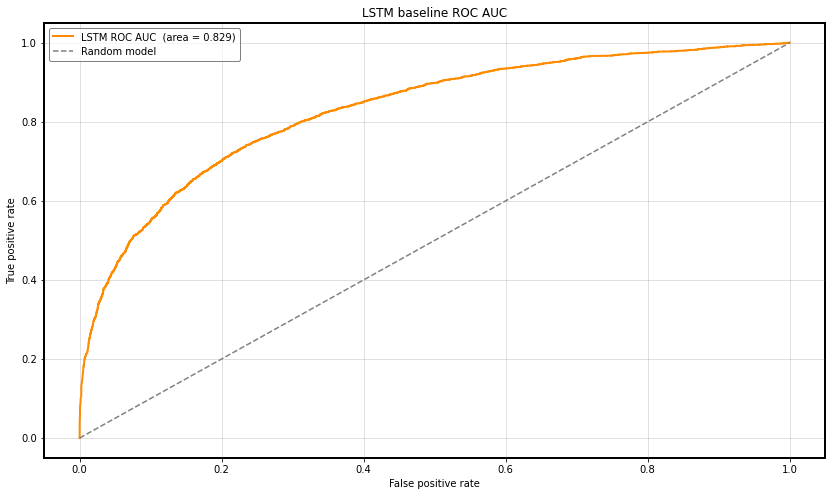

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import shutil
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
import tensorflow.keras.metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
import warnings
import time
from utils import my_precision,my_recall,my_f1,my_roc_auc,get_specificity,get_balanced_acc,plotConfusionMatrix,plotCurves,progressBar,plotROCCurve


warnings.filterwarnings('always')

path = "D:\Srikanth\Cough\CoughVID\Dataset_Classlabel\melspectograms"
names = sorted(os.listdir(path), key=lambda x: int(os.path.splitext(x)[0]))
imgArraySize = (88,39)

# Loading Images

images = []
for filename in progressBar(names, prefix = 'Reading:', suffix = '', length = 50):
    img = cv2.imread(os.path.join(path,filename))
    img = cv2.resize(img,imgArraySize)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.asarray(img,dtype=np.float32)
    img = img/225.0
    if img is not None:
        images.append(img)

images = np.squeeze(images)
# Loading Labels
labels = pd.read_csv('D:\Srikanth\Cough\CoughVID\Dataset_Classlabel\labels.csv')
labels.columns = ['label']
covid_status = labels["label"]
covid_status = np.asarray(covid_status)

rows = imgArraySize[1]
cols = imgArraySize[0]

if K.image_data_format() == 'channels_first':
    images = images.reshape(images.shape[0],rows,3*cols)
    input_shape = (rows,3*cols)
else:
    images = images.reshape(images.shape[0],rows,cols*3)
    input_shape = (rows, cols*3)
    
print("Dataset count: ",len(images)," Shape: ",images.shape)
print("Labels count: ",len(covid_status)," Shape: ",covid_status.shape)
print("Sample:")
plt.imshow(images[0])
print("Label: ",covid_status[0])

np.random.seed(75)

images,covid_status = shuffle(images,covid_status, random_state=75)
(trainX,testX,trainY,testY) = train_test_split(images,covid_status,test_size=0.2,shuffle=True)

del images,covid_status

print("Train set size : ",len(trainX))
print("Test set size : ",len(testX))

## Evaluation metrics

scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(my_precision),
           'recall':make_scorer(my_recall),
           'roc_auc':make_scorer(my_roc_auc),
           'f1':make_scorer(my_f1),
           'balanced_accuracy': 'balanced_accuracy'}

## Empty /kaggle/working + Free memory usage
# folder = './'
# for filename in os.listdir(folder):
#     file_path = os.path.join(folder, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))
# tf.keras.backend.clear_session()
# gc.collect()

## Start 10-fold cross-validation

num_folds = 10
fold_no = 1

acc_per_fold = []
recall_per_fold = []
precision_per_fold = []
roc_auc_per_fold = []
f1_per_fold = []
balanced_acc = []
specificity_per_fold = []
loss_per_fold = []
histories = []

METRICS = [
    tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
    tensorflow.keras.metrics.Precision(name='precision'),
    tensorflow.keras.metrics.Recall(name='recall'),
    tensorflow.keras.metrics.AUC(name='AUC')
]

kfold = KFold(n_splits=num_folds, shuffle=True,random_state=75)

for train,test in kfold.split(trainX,trainY):
    epochs = 50
    batch_size = 256
    learning_rate = 0.001
    optimizer = tensorflow.keras.optimizers.Adamax(learning_rate = learning_rate)
    filepath="model_best_weights_"+str(fold_no)+".hdf5"    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    ###### Model architecture
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    inputs = Input(shape=trainX[0].shape,name='input')
    x = LSTM(128, return_sequences=True)(inputs)
    x = Activation('tanh')(x)
    x = BatchNormalization()(x)
    x = LSTM(256, return_sequences=False)(x)
    x = Activation('tanh')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu',name="finallstm")(x)
    #x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1,name='output_layer')(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS)
    start = time.time()
    history = model.fit(trainX[train], trainY[train], batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(trainX[test],trainY[test]),callbacks=[checkpoint])
    end = time.time()
    print("Training time : ",(end-start))
    histories.append(history)
    scores = model.evaluate(trainX[test], trainY[test], verbose=0)
    covPredict = model.predict(trainX[test])
    covPredict = np.where(covPredict >= 0.5, 1,0)
    real_stat = trainY[test]
    acc_per_fold.append(scores[1])
    recall_per_fold.append(my_recall(real_stat, covPredict))
    precision_per_fold.append(my_precision(real_stat, covPredict))
    roc_auc_per_fold.append(my_roc_auc(real_stat, covPredict))
    f1_per_fold.append(my_f1(real_stat, covPredict))
    balanced_acc.append(get_balanced_acc(real_stat, covPredict))
    specificity_per_fold.append((2*get_balanced_acc(trainY[test],covPredict))-my_recall(trainY[test],covPredict))
    loss_per_fold.append(scores[0])
    model = load_model('model_best_weights_'+str(fold_no)+'.hdf5')
    score = model.evaluate(trainX[test],trainY[test], verbose=0)
    covPredict = model.predict(trainX[test])
    covPredict = np.where(covPredict >= 0.5, 1,0)
    print("Validation results for the fold "+str(fold_no)+":")
    print("Accuracy : ",score[1])
    print("Precision : ",my_precision(trainY[test],covPredict))
    print("Recall : ",my_recall(trainY[test],covPredict))
    print("F1 : ",my_f1(trainY[test],covPredict))
    print("ROC AUC : ",my_roc_auc(trainY[test],covPredict))
    print("Specificity : ",(2*get_balanced_acc(trainY[test],covPredict))-my_recall(trainY[test],covPredict))
    score = model.evaluate(testX,testY,verbose=0)
    covPredict = model.predict(testX)
    covPredict = np.where(covPredict >= 0.5, 1,0)
    print("Test results for the fold "+str(fold_no)+":")
    print("Accuracy : ",score[1])
    print("Precision : ",my_precision(testY,covPredict))
    print("Recall : ",my_recall(testY,covPredict))
    print("F1 : ",my_f1(testY,covPredict))
    print("ROC AUC : ",my_roc_auc(testY,covPredict))
    print("Specificity : ",(2*get_balanced_acc(testY,covPredict))-my_recall(testY,covPredict))
    fold_no = fold_no + 1

print("Accuracy per fold : ",acc_per_fold)
print("Precision per fold : ",precision_per_fold)
print("Recall per fold : ",recall_per_fold)
print("ROC AUC per fold : ",roc_auc_per_fold)
print("F1 per fold : ",f1_per_fold)
print("Specificity per fold : ",specificity_per_fold)

print("Mean Accuracy : ",np.mean(acc_per_fold))
print("std Accuracy : ",np.std(acc_per_fold))
print("Mean Precision : ",np.mean(precision_per_fold))
print("std Precision : ",np.std(precision_per_fold))
print("Mean Recall : ",np.mean(recall_per_fold))
print("std Recall : ",np.std(recall_per_fold))
print("Mean ROC AUC : ",np.mean(roc_auc_per_fold))
print("std ROC AUC : ",np.std(roc_auc_per_fold))
print("Mean F1 : ",np.mean(f1_per_fold))
print("std F1 : ",np.std(f1_per_fold))
print("Mean Specificity : ",np.mean(get_specificity(balanced_acc,recall_per_fold)))
print("std Specificity : ",np.std(get_specificity(balanced_acc,recall_per_fold)))

### Use the index of the best obtained model according to the test results

best_model = 10

model = load_model('model_best_weights_'+str(
    
    
    
    
    best_model)+'.hdf5')
score = model.evaluate(testX,testY, verbose=0)
covPredict = model.predict(testX)
covPredict = np.where(covPredict >= 0.5, 1,0)

## Plot confusion matrix
    
plotConfusionMatrix(testY,covPredict)

## Plot accuracy curves
plotCurves('LSTM train and validation accuracy curves','Accuracy','Epoch','accuracy',histories)

## Plot loss curves
plotCurves('LSTM train and validation loss curves','Loss','Epoch','loss',histories)

## Plot Sensitivity curves
plotCurves('LSTM train and validation sensitivity curves','Sensitivity','Epoch','recall',histories)

## Plot Precision curves
plotCurves('LSTM train and validation precision curves','Precision','Epoch','precision',histories)

## Plot ROC curve

probabilities = model.predict(testX).ravel()
fpr, tpr, thresholds = roc_curve(testY, probabilities, pos_label=1)
auc = auc(fpr, tpr)
plotROCCurve(fpr,tpr,auc,'darkorange','LSTM ROC AUC ','LSTM baseline ROC AUC')



In [9]:
watch -n 0.5 nvidia-smi

SyntaxError: invalid syntax (<ipython-input-9-17f7aa0b70eb>, line 1)